In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
%matplotlib inline

## Define functions to rotate velocities

In [2]:
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

## load test dataset

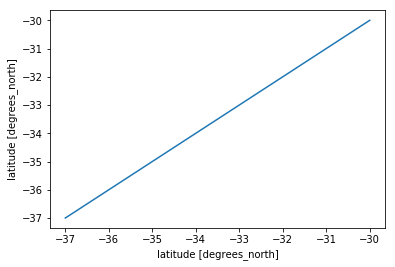

In [3]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_altimetry_EAC_region_1993_2019/IMOS_aggregation_20190307T030559Z.nc'
ds = xr.open_dataset(fname)
# interpolate to daily
ds = ds.resample(TIME='1D').interpolate('linear')
ds.LATITUDE.plot()

## Define line for Hovmoller - make plot to show where it is

In [4]:
start_lon = 154
start_lat = -31

end_lon = 150.6
end_lat = -36.4

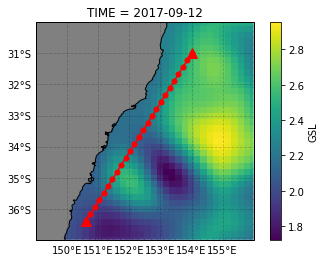

In [5]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

ax1 = plt.axes(projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
ds.GSL.sel(TIME = '2017-09-12').plot(transform=ccrs.PlateCarree())
plt.plot(start_lon, start_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
plt.plot(end_lon, end_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#make array of lats and lons for slicing
path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)
plt.plot(path_lons, path_lats, color='red', marker='o',markersize = 5)
#plt.savefig('dipole_section_location.pdf', dpi=300,bbox_inches='tight')

## Extract section along this line for Hovmoller

In [6]:
# use xarray advanced interpolation interp - can't seem to do this pairwise for latlon pairs, for the moment doing it in a loop
section = []
for x in range(25):
    px = ds.sel(LATITUDE=path_lats[x], LONGITUDE=path_lons[x],method = 'nearest') 
    section.append(px)
sec = xr.concat(section, dim=path_lats)

    

ang = np.deg2rad(27)
#rotate velocities normal to section
[u_rot, v_rot]=rotate(sec.UCUR,sec.VCUR,0,0, ang) 


Text(0.5,0,'Year')

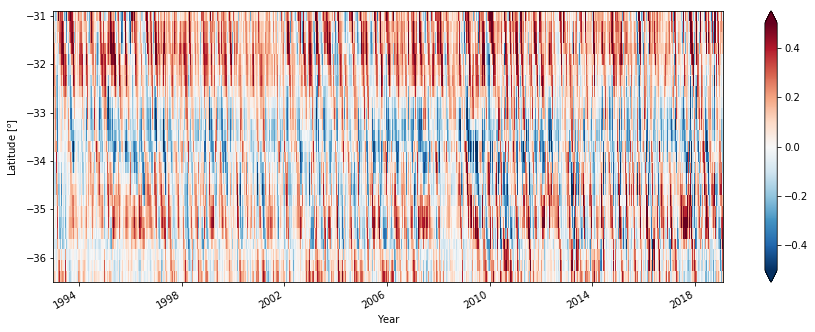

In [7]:
plt.figure(figsize=(15, 5))
u_rot.plot(vmin=-.5,vmax=.5,cmap='RdBu_r')
plt.ylabel('Latitude [$^o$]')
plt.xlabel('Year')
#plt.savefig('dipole_hovemoller.png', dpi=300,bbox_inches='tight')

## Plot time-mean of the Hovmoller

Text(0.5,0,'cross-track velocity [m/s]')

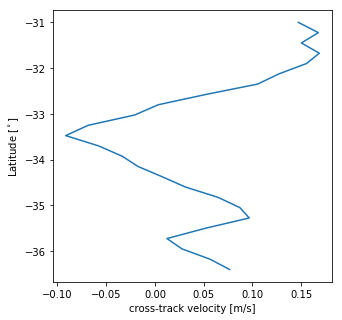

In [8]:
plt.figure(figsize=(5, 5))
u_rot.mean(axis = 1).plot(y='concat_dim')
plt.ylabel('Latitude [$^\circ$]')
plt.xlabel('cross-track velocity [m/s]')
#plt.savefig('dipole_hovemoller_mean.png', dpi=300,bbox_inches='tight')

## Get latitude of max onshore velocity at each timestep

In [9]:
u_rot.shape

(25, 9532)

In [10]:
onshore_lats=[]
for i in range(len(u_rot.TIME)):
    x = np.argmin(u_rot[:,i])
    ll = (x)
    onshore_lats.append(ll)
onshore_timeseries=path_lats[onshore_lats]

In [11]:
#get values at min of each column
ol=np.array(onshore_lats)
np.shape(ol)
onshore_u_min=u_rot[ol,:]

u_dipole=[]
for i in range(len(u_rot.TIME)):
    q = u_rot[ol[i],i]
    lll = (q)
    u_dipole.append(lll)
    

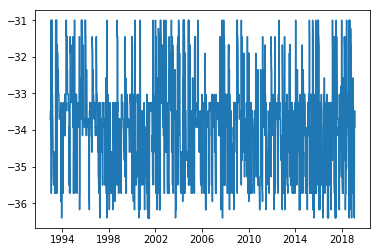

-33.92677035249686

In [12]:
mean_lat = np.mean(onshore_timeseries)
plt.plot(u_rot.TIME,onshore_timeseries)
plt.show()
mean_lat

In [13]:
onshore_lats = xr.concat(onshore_lats,dim='TIME')

## Save .nc of u_dipole (i.e. strength of strongest onshore velocity along section for each day) for spectral analysis

In [14]:
# save as netdcf for checking in matlab
# new_filename = 'EAC_xshelf_geostrophic_max_shelfsection_1993_2019.nc'
# u_dipole.to_netcdf(path=new_filename)

## Plot Histograms


Text(0,0.5,'Latitude [$^\\circ$]')

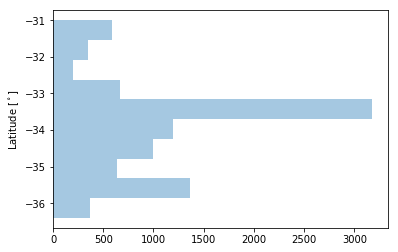

In [15]:
sns.distplot(onshore_timeseries,bins=10, vertical=True, kde=False);
plt.ylabel('Latitude [$^\circ$]')
#plt.savefig('dipole_histogram_no_threshold.png', dpi=300,bbox_inches='tight')

## Convert u_dipole from list into dataarray

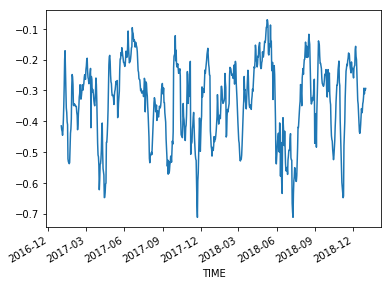

In [16]:
u_dipole = xr.concat(u_dipole,dim='TIME')
u_dipole.sel(TIME=slice('2017-01-01', '2018-12-31')).plot()

## Impose threshold

In [17]:
# create a categorical  dataarray
dip_index = xr.full_like(u_dipole, 'none', dtype='U6')
dip_index[u_dipole >= -.25] = 'normal'
dip_index[u_dipole <= -.25] = 'dipole'
dip_index

<xarray.DataArray (TIME: 9532)>
array([u'normal', u'normal', u'normal', ..., u'normal', u'normal', u'normal'],
      dtype='<U6')
Coordinates:
  * TIME        (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05
    LONGITUDE   (TIME) float32 152.4 152.4 152.4 152.4 ... 152.2 152.2 152.2
    LATITUDE    (TIME) float32 -33.8 -33.8 -33.4 -33.4 ... -34.0 -34.0 -34.0
    concat_dim  (TIME) float64 -33.7 -33.7 -33.48 ... -33.92 -33.92 -33.92

## plot composites using threshold

/home/z3526974/anaconda2/lib/python2.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


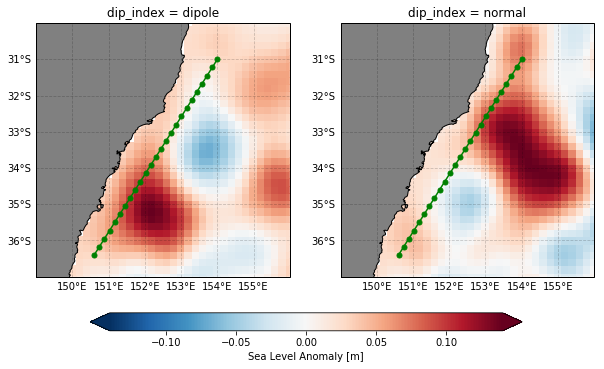

In [18]:
sla_dipole_composite = ds.GSLA.groupby(dip_index.rename('dip_index')).mean(dim='TIME')

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
im = sla_dipole_composite.sel(dip_index='dipole').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

ax1 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
sla_dipole_composite.sel(dip_index='normal').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

cbar_ax = fig.add_axes([0.2, -0.0, .6, .05]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Level Anomaly [m]')
#plt.savefig('dipole_composite_025.pdf', dpi=300,bbox_inches='tight')
plt.show()

In [19]:
dipole_composite_timeseries = u_dipole.groupby(dip_index.rename('dip_index')).values

AttributeError: 'DataArrayGroupBy' object has no attribute 'values'

## plot histogram of dipole composite, need to convert u_dipole to a dataframe to do this

In [20]:
df = u_dipole.to_dataframe(name = 'U');

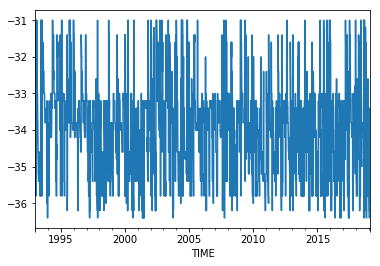

In [21]:
df.LATITUDE.plot()
#plt.savefig('dipole_timeseries_raw.png', dpi=300,bbox_inches='tight')

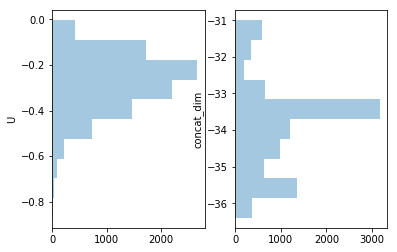

In [22]:
plt.subplot(1,2,1)
sns.distplot( df[ "U" ] ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[ "concat_dim" ] ,bins=10, vertical = True, kde=False )
plt.savefig('dipole_hist_raw.png', dpi=300,bbox_inches='tight')

## Groupby threshold (in pandas this time)

In [23]:
dipole = df['U'] < -.25

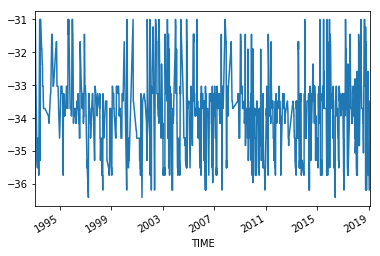

In [24]:
df[dipole].concat_dim.plot()
plt.savefig('dipole_timeseries_025.png', dpi=300,bbox_inches='tight')

LONGITUDE     5195
LATITUDE      5195
concat_dim    5195
U             5195
dtype: int64

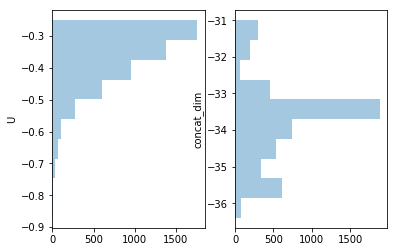

In [25]:
plt.subplot(1,2,1)
sns.distplot( df[dipole].U ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[dipole].concat_dim ,bins=10, vertical = True, kde=False )
plt.savefig('dipole_hist_025.png', dpi=300,bbox_inches='tight')
df[dipole].count()

In [26]:
df[dipole].U.size

5195

In [27]:
ds

<xarray.Dataset>
Dimensions:     (LATITUDE: 36, LONGITUDE: 31, TIME: 9532)
Coordinates:
  * TIME        (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05
  * LONGITUDE   (LONGITUDE) float32 150.0 150.2 150.4 ... 155.6 155.8 156.0
  * LATITUDE    (LATITUDE) float32 -37.0 -36.8 -36.6 -36.4 ... -30.4 -30.2 -30.0
Data variables:
    start_time  (TIME) float64 7.246e+17 7.249e+17 ... 1.548e+18 1.548e+18
    end_time    (TIME) float64 7.271e+17 7.27e+17 ... 1.55e+18 1.551e+18
    GSLA        (TIME, LATITUDE, LONGITUDE) float64 -0.05936 -0.03922 ... 0.1177
    GSL         (TIME, LATITUDE, LONGITUDE) float64 1.953 1.975 ... 2.671 2.688
    UCUR        (TIME, LATITUDE, LONGITUDE) float64 -0.0264 -0.03952 ... -0.3885
    VCUR        (TIME, LATITUDE, LONGITUDE) float64 -0.06806 -0.1762 ... -0.1012

# Aggregate figures for paper

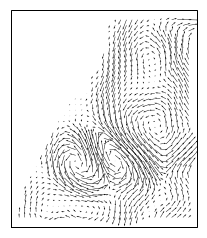

In [49]:

ax = plt.axes(projection=ccrs.PlateCarree())
X,Y = np.meshgrid(ds.LONGITUDE,ds.LATITUDE)
u = ds.UCUR.sel(TIME='2017-09-13')
v = ds.VCUR.sel(TIME='2017-09-13')
q = plt.quiver(X,Y,u,v,angles='xy',scale=10,color='k')
    

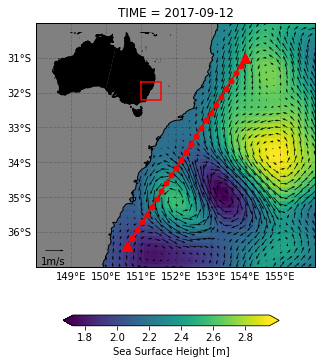

In [57]:
#plot map and location of shelf section
fig = plt.figure(figsize=(5,5))
# ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
# feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
# ax1.set_extent([140, 175, -45, -5])
# gl = ax1.gridlines(draw_labels=True,
#              color='black', alpha=0.2, linestyle='--')
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# ax1.add_patch(mpatches.Rectangle(xy=[149, -37], width=7, height=7,
#                                     facecolor='blue',
#                                     alpha=0.2,
#                                     transform=ccrs.PlateCarree())
#                  )

ax2 = plt.axes(projection=ccrs.PlateCarree())
feature = ax2.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.GSL.sel(TIME = '2017-09-12').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
plt.plot(start_lon, start_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
plt.plot(end_lon, end_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
ax2.set_extent([148, 156, -37, -30])
gl = ax2.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#add geostrophi current arrows
X,Y = np.meshgrid(ds.LONGITUDE,ds.LATITUDE)
u = ds.UCUR.sel(TIME='2017-09-12')
v = ds.VCUR.sel(TIME='2017-09-12')
q = plt.quiver(X,Y,u,v,angles='xy',scale=15,color='k',transform=ccrs.PlateCarree())

plt.quiverkey(q, X=148.5, Y=-36.5, U=1, color='black',coordinates='data',
             label='1m/s', labelpos='S')

#plot section location
path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)
plt.plot(path_lons, path_lats, color='red', marker='o',markersize = 5)

cbar_ax = fig.add_axes([0.2, -0.0, .6, .03]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Surface Height [m]')

ax = fig.add_axes([.15,.51,.35,.35],projection=ccrs.PlateCarree())
ax.set_extent([110, 160, -45, -10])
feature = ax.add_feature(coast, edgecolor='black',facecolor='black')
 # to get the effect of having just the land without a map "background"
 # turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

x = [148, 148, 156, 156, 148]
y = [-30, -37, -37, -30, -30]
ax.plot(x, y, transform=ccrs.PlateCarree(),color = 'red')
plt.savefig('dipole_intro_map.eps', dpi=300,bbox_inches='tight')
plt.savefig('dipole_intro_map.png', dpi=300,bbox_inches='tight')
plt.show()

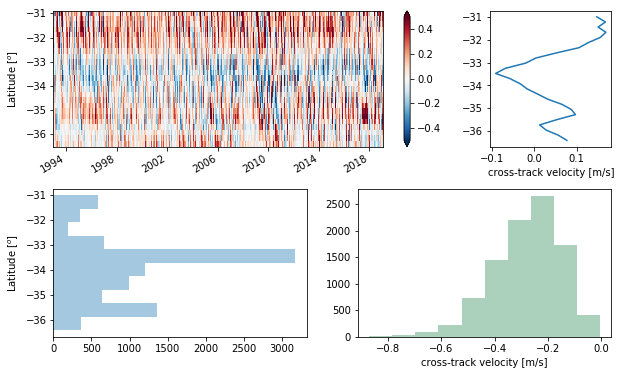

In [27]:
#plot cross-shelf info - before compositing
grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.4)
plt.figure(figsize=(10,6))
plt.subplot(grid[0, :3])
u_rot.plot(vmin=-.5,vmax=.5,cmap='RdBu_r')
plt.ylabel('Latitude [$^o$]')
plt.xlabel('')

plt.subplot(grid[0, 3:])
u_rot.mean(axis = 1).plot(y='concat_dim')
plt.ylabel('')
plt.xlabel('cross-track velocity [m/s]')

plt.subplot(2,2,3)
sns.distplot( df[ "concat_dim" ] ,bins=10, vertical = True, kde=False )
plt.ylabel('Latitude [$^o$]')
plt.subplot(2,2,4)
sns.distplot( df[ "U" ] ,bins=10,kde=False, color='seagreen' )
plt.xlabel('cross-track velocity [m/s]')

plt.savefig('dipole_hovmoller_combined.pdf', dpi=300,bbox_inches='tight')
plt.show()

## Load SST data

In [28]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_SST_1993_2019/IMOS_aggregation_20190314T220014Z.nc'
sst = xr.open_dataset(fname)
sst

<xarray.Dataset>
Dimensions:                  (lat: 100, lon: 100, time: 9719)
Coordinates:
  * lat                      (lat) float32 -32.01 -32.03 ... -33.97 -33.99
  * lon                      (lon) float32 151.01 151.03 ... 152.97 152.99
  * time                     (time) datetime64[ns] 1992-03-21T15:20:00 ... 2019-03-11T15:20:00
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 ...
    sst_dtime                (time, lat, lon) float32 ...
    dt_analysis              (time, lat, lon) float32 ...
    satellite_zenith_angle   (time, lat, lon) float32 ...
    l2p_flags                (time, lat, lon) float32 ...
    quality_level            (time, lat, lon) float32 ...
    sses_bias                (time, lat, lon) float32 ...
    sses_standard_deviation  (time, lat, lon) float32 ...
    sses_count               (time, lat, lon) float32 ...
Attributes:
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    summary:                    

## load Chla data

In [29]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_SST_1993_2019/IMOS_aggregation_20190314T220220Z.nc'
chla = xr.open_dataset(fname,decode_times=False)
chla

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 201, time: 6040)
Coordinates:
  * latitude   (latitude) float64 -32.0 -32.01 -32.02 ... -33.98 -33.99 -34.0
  * time       (time) float64 7.396e+04 7.396e+04 ... 8.006e+04 8.006e+04
  * longitude  (longitude) float64 151.0 151.0 151.0 151.0 ... 153.0 153.0 153.0
Data variables:
    chl_oc3    (time, latitude, longitude) float32 ...
    l2_flags   (time, latitude, longitude) float64 ...
Attributes:
    source_path:                      imos-srs/archive/oc/aqua/1d/v201508/200...
    compliance_checker_version:       1.1.1 (79b23fe87f7e932974b93f7bdc1de29d...
    compliance_checker_last_updated:  2016-01-21 01:31:49 UTC
    history:                          Wed Dec 16 15:07:47 2015: ncks -A -v l2...
    history_of_appended_files:        Wed Dec 16 15:07:47 2015: Appended file...
    NCO:                              20151216
    Conventions:                      CF-1.6
    time_coverage_start:              2002-07-05T00:00:00Z
   

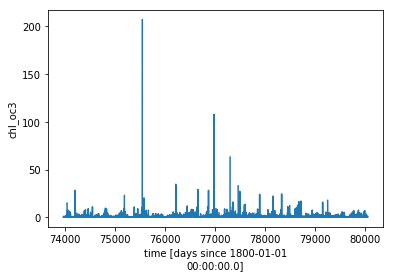

In [30]:
chla.chl_oc3.mean(dim=('longitude','latitude')).plot()
plt.savefig('stockton_Chla.png', dpi=300,bbox_inches='tight')